In [171]:
import config
import functions
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

In [172]:
from jupyterthemes import jtplot

jtplot.style(theme='gruvboxd')

In [173]:
logreg = LogisticRegression(C=1, penalty='l1',
fit_intercept=True, max_iter=700, random_state=42, # l1_ratio=0.8,
                    solver='saga', n_jobs=-1, verbose=0)

In [229]:
X, y = functions.load_taxonomy(boolean=True)

In [245]:
def get_gmhi_values(logreg, X, y):
    logreg.fit(X, y)
    gmhi_values = pd.DataFrame(logreg.decision_function(X))
    gmhi_values.columns = ['gmhi_value']
    gmhi_values.index = X.index
    return gmhi_values.sort_values('gmhi_value')

In [246]:
gmhi_values = get_gmhi_values(logreg, X, y)
gmhi_values

gmhi_value
Study Accession Sample Accession or Sample ID            
PRJEB15371      SAMEA4431901                   -10.447666
PRJEB21528      SAMEA104142301                  -9.259069
                SAMEA104142237                  -9.117482
                SAMEA104142095                  -8.765672
N7              SAMN08813993                    -8.055505
...                                                   ...
PRJEB11532      SAMEA3665166                     5.870525
                SAMEA3664581                     6.227058
                SAMEA3664661                     6.456062
                SAMEA3664637                     6.813762
                SAMEA3664545                     9.751145

[5026 rows x 1 columns]

In [177]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [203]:
def get_top_transformed(X, y, gmhi_values, num_top, metric):
    mds = MDS(n_components=2, random_state=42, n_jobs=-1, verbose=10, dissimilarity='precomputed')
    top_X = X.loc[gmhi_values.iloc[:num_top, :].index | gmhi_values.iloc[-num_top:, :].index]
    distances = pairwise_distances(top_X, n_jobs=-1, metric=metric)
    transformed = pd.DataFrame(mds.fit_transform(distances))
    transformed.index = top_X.index
    transformed.columns = ['MDS1', 'MDS2']
    transformed['isHealthy'] = y
    return transformed

In [204]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [226]:
def plot_top_values(X, y, gmhi_values, num_top, metric, ax, title, transformed=None):
    if transformed is None:
        transformed = get_top_transformed(X, y, gmhi_values, num_top, metric)
    sns.scatterplot(ax=ax, data=transformed, x="MDS1", y="MDS2", 
                    hue="isHealthy", palette=['r', 'b'], s=10)

    # create confidence ellipse for healthy and unhealthy
    healthies = transformed[transformed['isHealthy']]
    unhealthies = transformed[~transformed['isHealthy']]
    confidence_ellipse(healthies['MDS1'], healthies['MDS2'], ax, n_std=2.0, 
                       edgecolor=(0.2, 0.45, 0.78, 1), linewidth=5, facecolor=(0.2, 0.45, 0.78, 0.1))
    confidence_ellipse(unhealthies['MDS1'], unhealthies['MDS2'], ax, n_std=2.0, 
                       edgecolor=(0.77, 0.31, 0.32, 1), linewidth=5, facecolor=(0.77, 0.31, 0.32, 0.1))
    ax.set_title(title, fontsize=30)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.9s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent wo

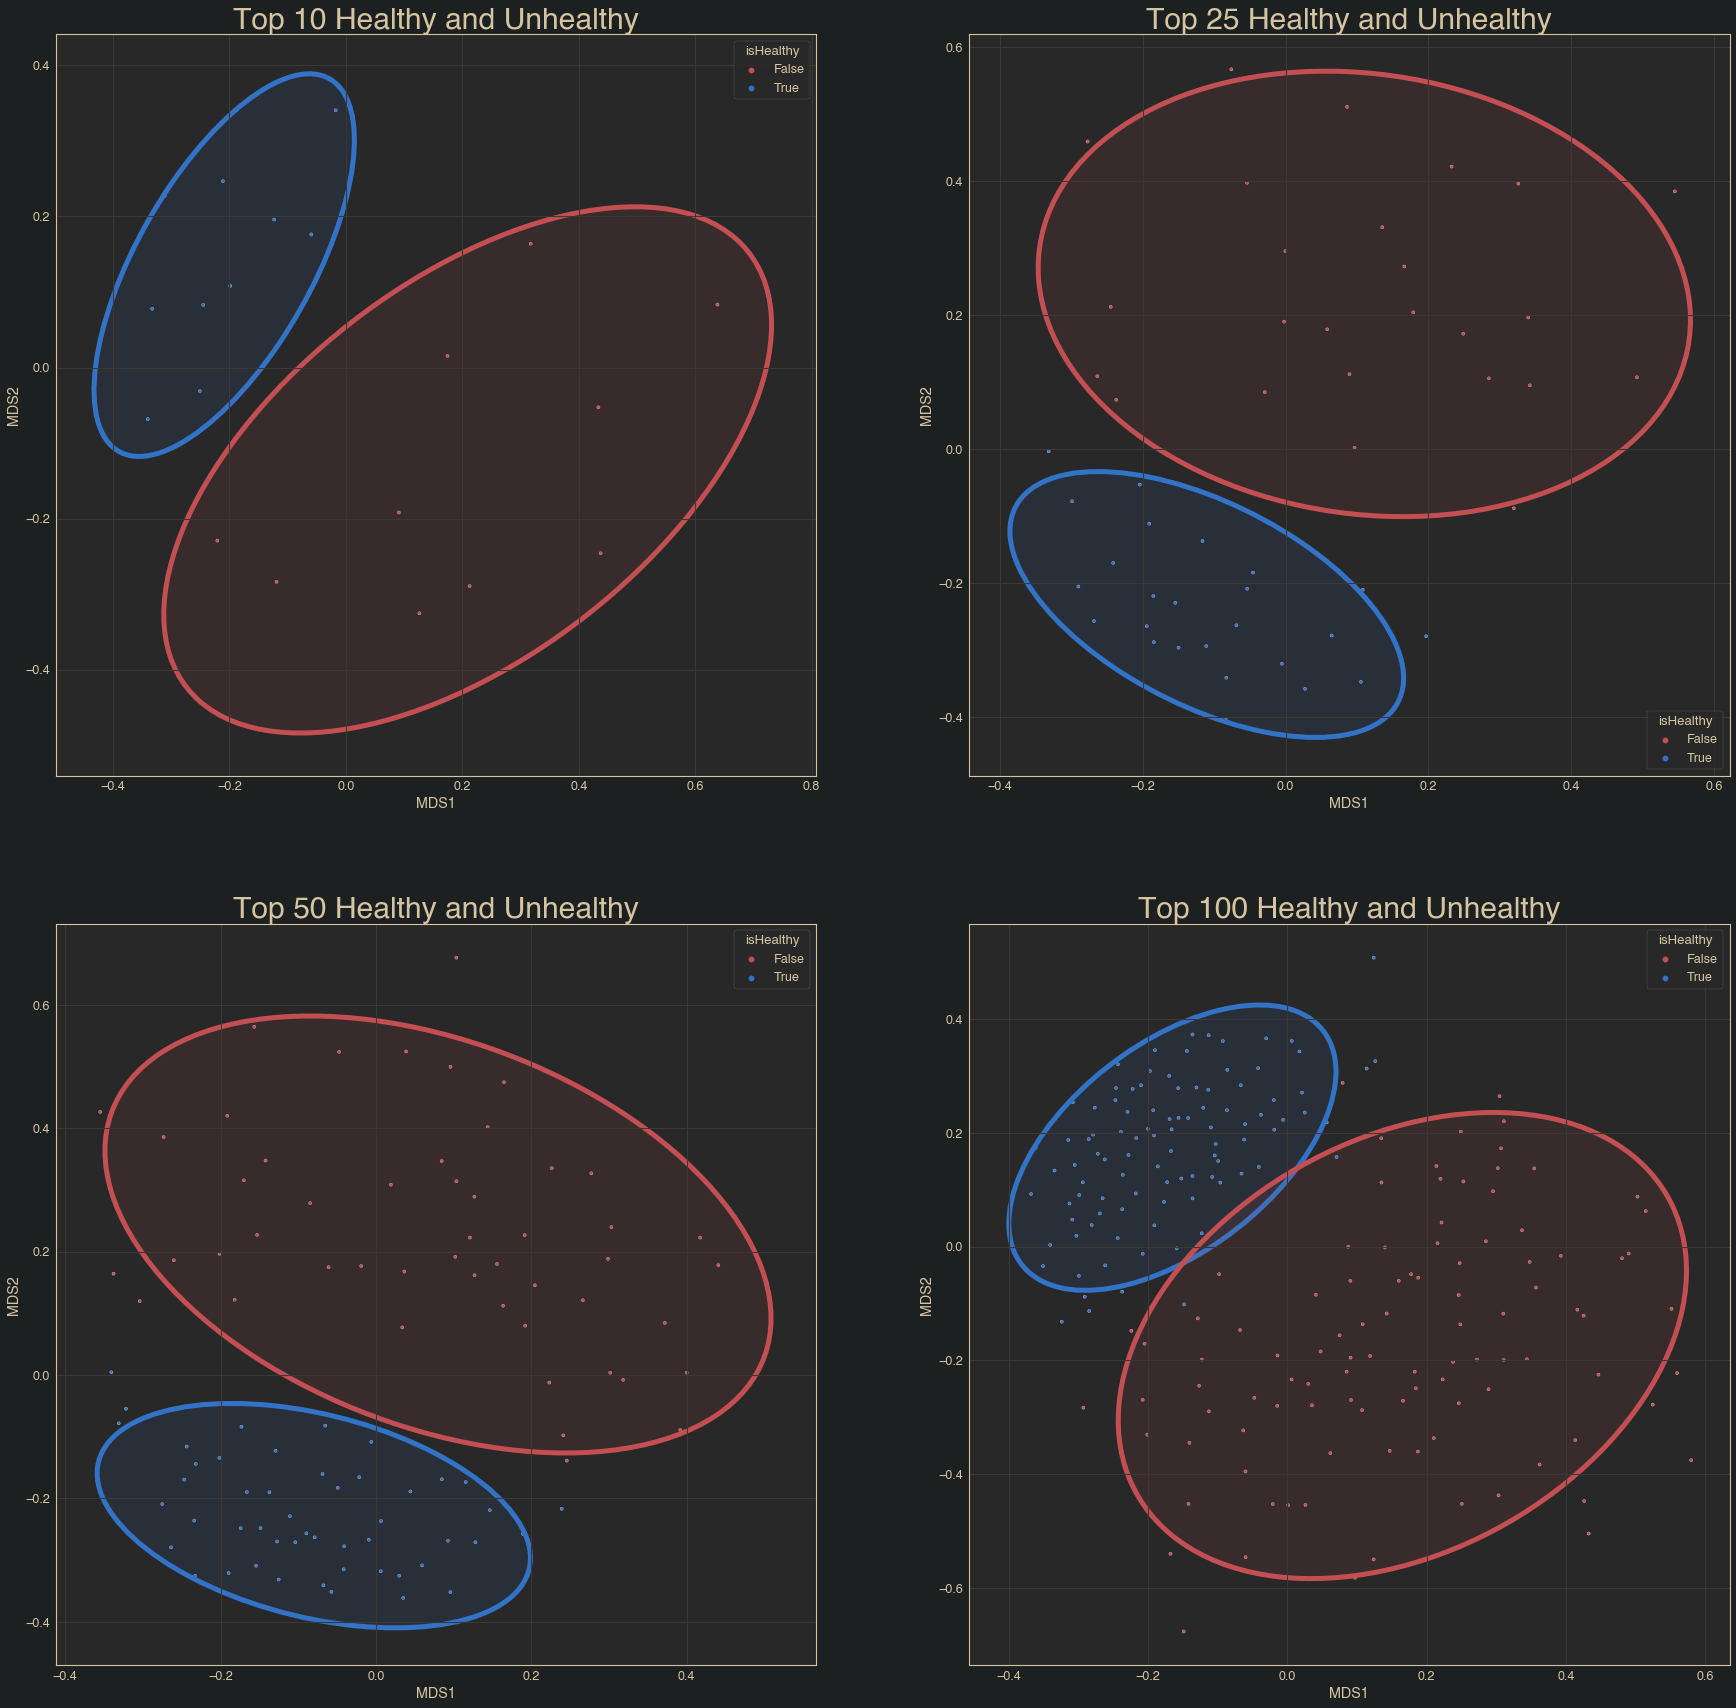

In [228]:
metric= 'braycurtis'
fig, axes = plt.subplots(2, 2, figsize=(30, 30))
axes = axes.flatten()

for idx, num_top in enumerate([10, 25, 50, 100]):
    ax = axes[idx]
    title = "Top " + str(num_top) + " Healthy and Unhealthy"
    plot_top_values(X, y, gmhi_values, num_top, metric, ax, title)
plt.savefig(config.OUTPUT_DIR + "MDS.png")

In [ ]:
%%time
transformed = get_top_transformed(X, y, gmhi_values, X.shape[0], metric)

In [223]:
transformed

MDS1      MDS2  isHealthy
Study Accession Sample Accession or Sample ID                               
PRJEB15371      SAMEA4431901                  -0.288211  0.542160      False
PRJEB21528      SAMEA104142301                -0.039014  0.481915      False
                SAMEA104142237                -0.049084  0.500762      False
                SAMEA104142095                -0.169010  0.570059      False
N7              SAMN08813993                  -0.125341  0.477658      False
...                                                 ...       ...        ...
PRJEB11532      SAMEA3665166                   0.290444 -0.036983       True
                SAMEA3664581                   0.117003 -0.031208       True
                SAMEA3664661                   0.286201 -0.081450       True
                SAMEA3664637                   0.167616 -0.013501       True
                SAMEA3664545                   0.190753  0.167671       True

[5026 rows x 3 columns]

In [224]:
transformed.to_csv(config.OUTPUT_DIR + "mds_all.csv")

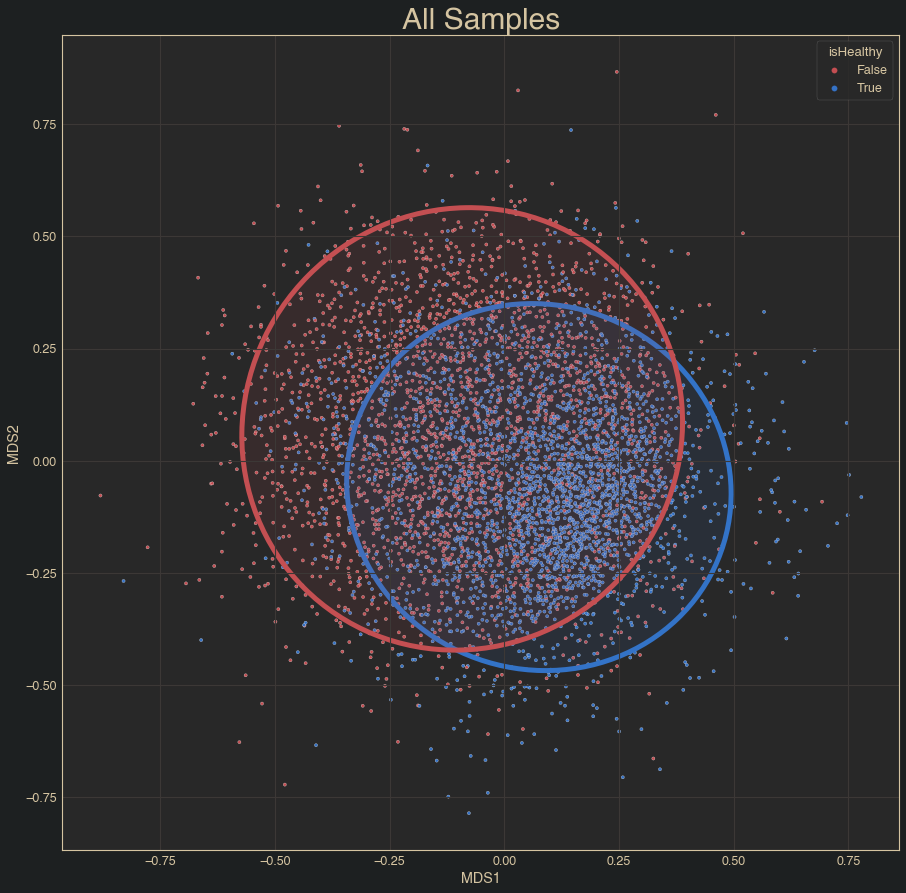

In [227]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_top_values(X, y, gmhi_values, X.shape[0], metric, ax, "All Samples", transformed)
plt.savefig(config.OUTPUT_DIR + "MDS_all.png")